# Problem Statement: 
**Forecast the CocaCola prices and Airlines Passengers data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.**

In [230]:
import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

In [231]:
Data = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
Data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


# EDA and Data visualization

In [232]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


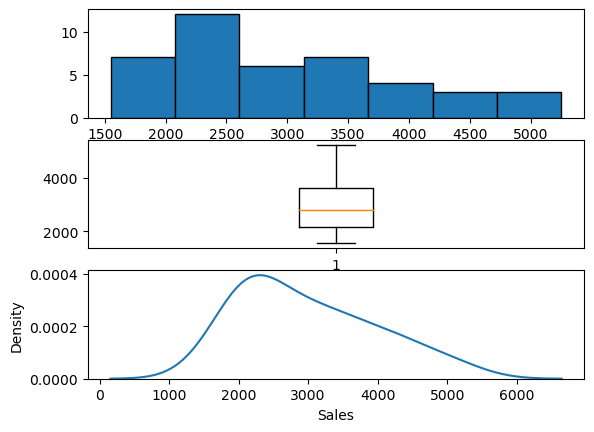

In [233]:

plt.subplot(311)
plt.hist(Data.Sales, bins =7, edgecolor = 'black')
plt.subplot(312)
plt.boxplot(Data.Sales)
plt.subplot(313)
sns.kdeplot(Data.Sales)
plt.show()

In [234]:
temp = Data.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1')
Data['quarter'] = pd.to_datetime(temp).dt.strftime('%b-%Y')
Data.head()

,Quarter,Sales,quarter
0,Q1_86,1734.827000,Jan-1986
1,Q2_86,2244.960999,Apr-1986
2,Q3_86,2533.804993,Jul-1986
3,Q4_86,2154.962997,Oct-1986
4,Q1_87,1547.818996,Jan-1987


In [235]:
Data['Date'] = pd.to_datetime(Data['quarter'])
Data.drop(["Quarter", "quarter"], axis = 1, inplace =True)
Data.head()

,Sales,Date
0,1734.827000,1986-01-01
1,2244.960999,1986-04-01
2,2533.804993,1986-07-01
3,2154.962997,1986-10-01
4,1547.818996,1987-01-01


In [236]:
Data["month"] = Data.Date.dt.strftime("%b") # month extraction
Data["year"] = Data.Date.dt.strftime("%Y") # year extraction
Data.rename(columns = {"Sales":"sales"}, inplace = True)

In [237]:
heatmap_y_month = pd.pivot_table(data=Data,values="sales",index="year",columns="month",aggfunc="mean",fill_value=0)
heatmap_y_month

month,Apr,Jan,Jul,Oct
year,,,,
1986,2244.960999,1734.827000,2533.804993,2154.962997
1987,2104.411995,1547.818996,2014.362999,1991.746998
1988,2313.631996,1869.049999,2128.320000,2026.828999
1989,2331.164993,1910.603996,2206.549995,2173.967995
1990,2739.307999,2148.278000,2792.753998,2556.009995
1991,3039.522995,2480.973999,3172.115997,2879.000999
1992,3550.000000,2772.000000,3508.000000,3243.859993
1993,3899.000000,3056.000000,3629.000000,3373.000000
1994,4342.000000,3352.000000,4461.000000,4017.000000


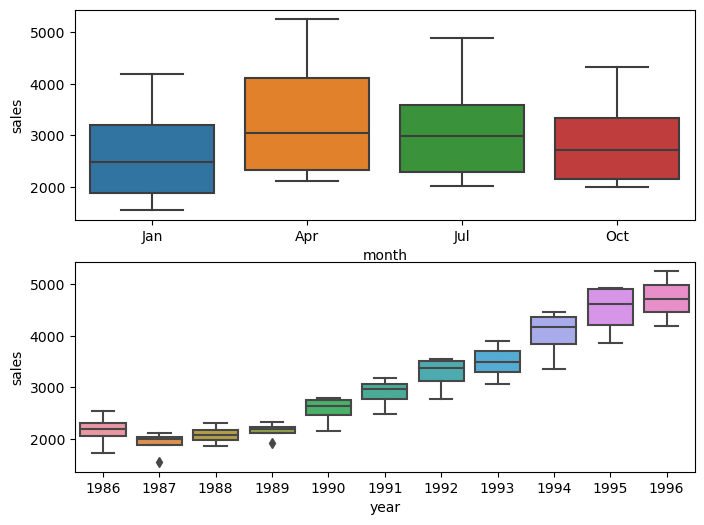

In [238]:
# Boxplots
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="month",y="sales",data=Data)
plt.subplot(212)
sns.boxplot(x="year",y="sales",data=Data)
plt.show()

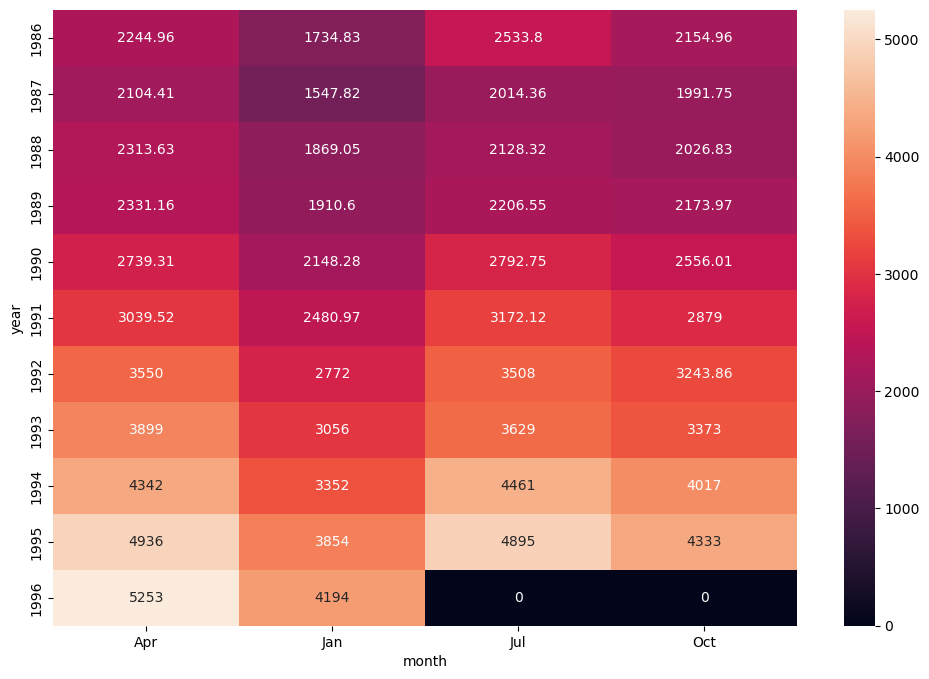

In [239]:
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_y_month,annot=True,fmt="g"); #fmt is format of the grid values

<AxesSubplot:>

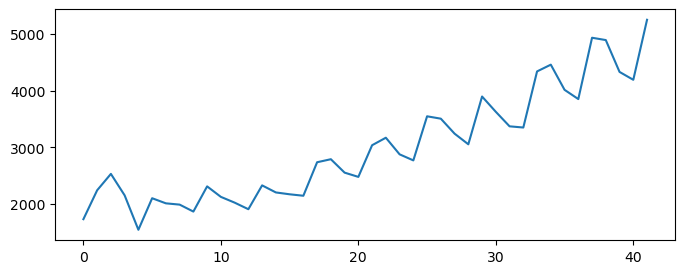

In [240]:
Data['sales'].plot(figsize=(8, 3))

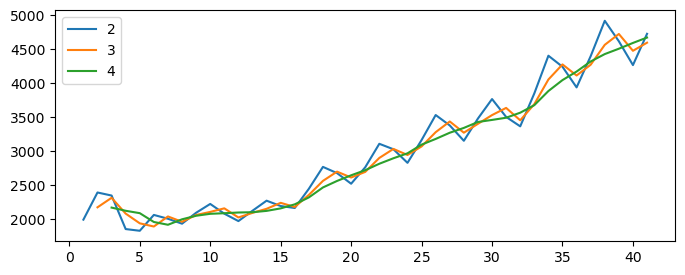

In [241]:
plt.figure(figsize=(8,3))
for i in range(2,5,1):
     Data["sales"].rolling(i).mean().plot(label=str(i))

plt.legend(loc=2)
plt.show()

**rolling avarage over a quarter makes the series stationary**

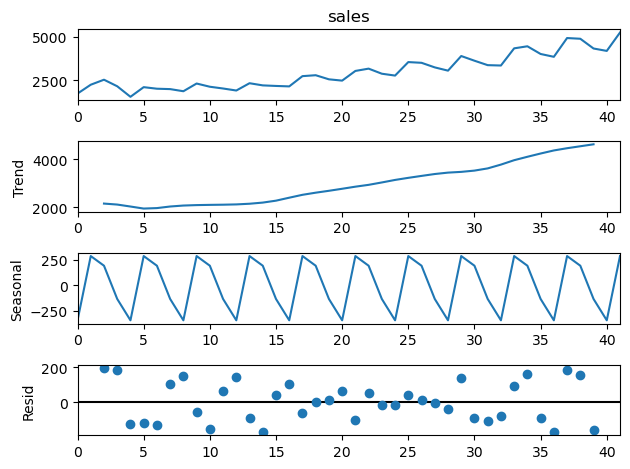

In [242]:
# decompose the data using additive model
from statsmodels.tsa.seasonal import seasonal_decompose
ts_add = seasonal_decompose(Data.sales, model="additive", period =4)
fig = ts_add.plot()
plt.show()

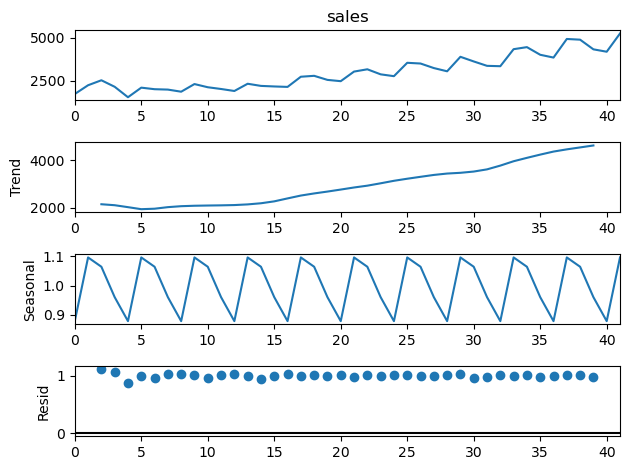

In [243]:
# decompose the data using multiplicative model
from statsmodels.tsa.seasonal import seasonal_decompose
ts_mul = seasonal_decompose(Data.sales,model="multiplicative", period =4)
fig = ts_mul.plot()
plt.show()

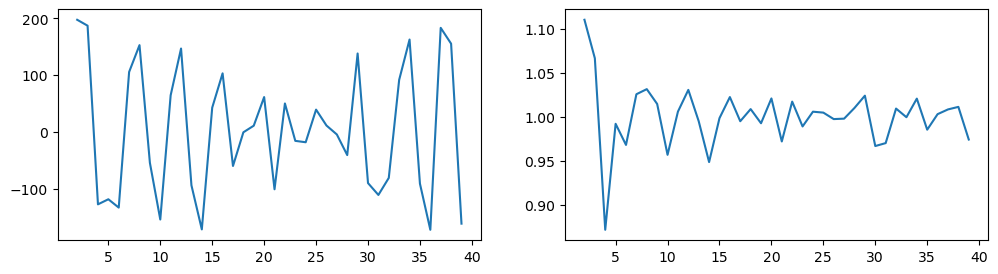

In [244]:
# residual distributions for the additive and multiplicatve
residual_mul = ts_mul.resid
residual_add = ts_add.resid
plt.figure(figsize=(12,3))
plt.subplot(121)
residual_add.plot()
#residual_add.hist(bins = 10, edgecolor = 'black')
plt.subplot(122)
residual_mul.plot()
#residual_mul.hist(bins = 10, edgecolor = "black")
plt.show()

variance from the two residual plots suggests and additive model will be more appropriate than the multiplicative one.

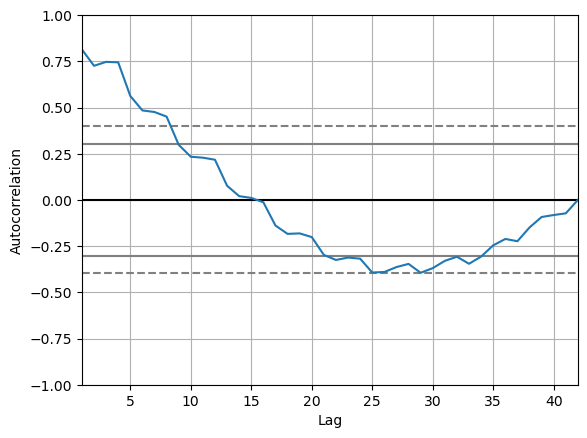

In [245]:
# create an autocorrelation plot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(Data.sales)
plt.show()

**positive correlation with the first 15 lags that is perhaps significant for the first 8 lags**

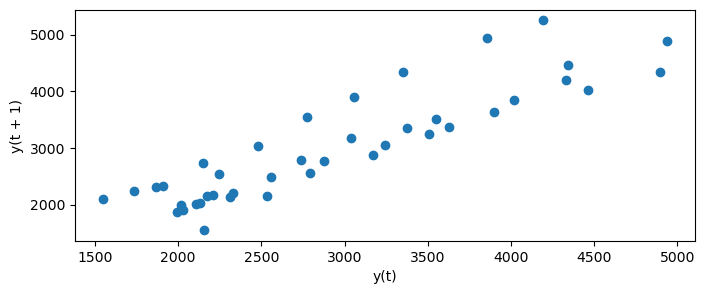

In [246]:
plt.figure(figsize = (8,3))
lag_plot(Data.sales)
plt.show()

**A lag plot checks whether a data set or time series is random or not. Random data should not exhibit any identifiable structure in the lag plot. Non-random structure in the lag plot indicates that the underlying data are not random.  
"sales" shows a linear pattern in the lag-plot which means the data is not random and suggests that an autoregressive model might be appropriate.**

# Data preparation

In [144]:
#sqrt transformation
from numpy import log
Data['sales_log'] = log(Data.sales)


In [145]:
# creating dummy variables for the column month
df = pd.get_dummies(Data["month"])
df.head()
df1 = pd.concat([Data,df], axis=1)
df1["t"] = range(1,(len(Data.sales)+1))
df1["t_square"] = df1["t"]*df1["t"]
df1.head()

,sales,Date,month,year,sales_log,Apr,Jan,Jul,Oct,t,t_square
0,1734.827000,1986-01-01,Jan,1986,7.458663,0,1,0,0,1,1
1,2244.960999,1986-04-01,Apr,1986,7.716443,1,0,0,0,2,4
2,2533.804993,1986-07-01,Jul,1986,7.837477,0,0,1,0,3,9
3,2154.962997,1986-10-01,Oct,1986,7.675529,0,0,0,1,4,16
4,1547.818996,1987-01-01,Jan,1987,7.344602,0,1,0,0,5,25


# model preparation

**Model based forcasting**

In [146]:
#splitting the data
train = df1.head(25)
test = df1.tail(10)

In [147]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('sales~t',data=train).fit()
pred_linear =  pd.Series(linear_model.predict(test[["t"]]))
rmse_linear = np.sqrt(np.mean((np.array(test['sales'])-np.array(pred_linear))**2))
rmse_linear

1133.310783111455

In [148]:
#Quadratic 

Quad = smf.ols('sales~t+t_square',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_square"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['sales'])-np.array(pred_Quad))**2))
rmse_Quad

734.8297761154423

In [149]:
#Exponential

Exp = smf.ols('sales_log~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(test[["t","t_square"]]))
rmse_Exp = np.sqrt(np.mean((np.array(test['sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

953.7254314085856

In [150]:
#Additive seasonality 
add_sea = smf.ols('sales~Jan+Apr+Jul+Oct',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan', 'Apr', 'Jul', 'Oct']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

2091.07404838755

In [151]:
#Additive Seasonality Quadratic 
add_sea_Quad = smf.ols('sales~t+t_square+Jan+Apr+Jul+Oct',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan', 'Apr', 'Jul', 'Oct','t','t_square']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

1027.0716151100478

In [152]:
##Multiplicative Seasonality
Mul_sea = smf.ols('sales_log~Jan+Apr+Jul+Oct',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

2117.6189882643707

In [153]:
#Multiplicative Seasonality Quadratic 
mult_sea_Quad = smf.ols('sales_log~t+t_square+Jan+Apr+Jul+Oct',data=train).fit()
pred_mult_sea_quad = pd.Series(mult_sea_Quad.predict(test[['Jan', 'Apr', 'Jul', 'Oct','t','t_square']]))
rmse_mult_sea_quad = np.sqrt(np.mean((np.array(test['sales'])-np.array(pred_mult_sea_quad))**2))
rmse_mult_sea_quad


4387.255155843499

In [154]:
#Multiplicative Additive Seasonality 
Mul_Add_sea = smf.ols('sales_log~t+Jan+Apr+Jul+Oct',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test['sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

804.1790718634501

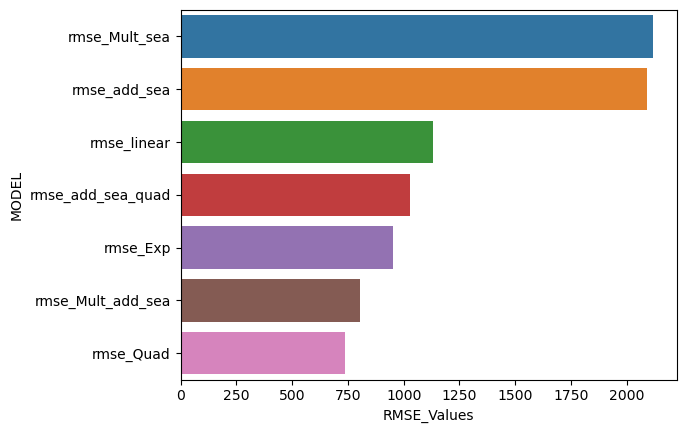

In [155]:
results1 = {"MODEL":["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"],
           "RMSE_Values":[rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea]}
table_rmse1=pd.DataFrame(data=results1)
sns.barplot(data=table_rmse1.sort_values(['RMSE_Values'],ascending=False), x="RMSE_Values", y="MODEL")
plt.show()

# Data Driven Models for forcasting

In [88]:
#neccessary libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [97]:
# evaluation matrix, root mean square error
def rmse(org,pred):
    temp = np.sqrt(np.abs((org-pred)**2))
    return np.mean(temp)

In [156]:
#Simple exponential method
ses_model = SimpleExpSmoothing(train["sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
pe1 = rmse(pred_ses,test.sales) 
pe1

1641.680690469587

In [157]:
# Holt method 
hw_model = Holt(train["sales"]).fit(smoothing_level=0.8, smoothing_trend=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
pe2 = rmse(pred_hw,test.sales) 
pe2

1262.6546460920856

In [100]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["sales"],seasonal="add",trend="add",seasonal_periods=4).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
pe3 = rmse(pred_hwe_add_add,test.sales) 
pe3

718.350803013252

In [158]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["sales"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
pe4 = rmse(pred_hwe_mul_add,test.sales)
pe4

213.95699440551175

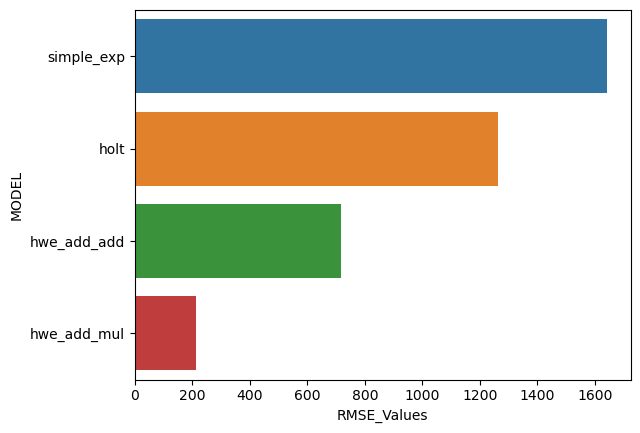

In [159]:
results2 = {"MODEL":["simple_exp","holt","hwe_add_add","hwe_add_mul"],
           "RMSE_Values":[pe1,pe2,pe3,pe4]}
table_rmse2=pd.DataFrame(data=results2)
sns.barplot(data=table_rmse2.sort_values(['RMSE_Values'],ascending=False), x="RMSE_Values", y="MODEL")
plt.show()

# Model ARIMA

In [160]:
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA



In [203]:
#splitting the data
X = df1['sales'].values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
print(train.size)
print(test.size)

29
13


In [204]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()      
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [205]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                        print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [206]:
# evaluate parameters
p_values = range(1, 5)
d_values = range(1, 5)
q_values = range(1, 3)
evaluate_models(train, p_values, d_values, q_values)

ARIMA(1, 1, 1) RMSE=567.044
ARIMA(1, 1, 2) RMSE=543.736
ARIMA(2, 1, 1) RMSE=462.048
ARIMA(2, 1, 2) RMSE=362.595
ARIMA(3, 1, 1) RMSE=293.957
ARIMA(3, 1, 2) RMSE=262.611
ARIMA(3, 2, 1) RMSE=188.563
ARIMA(3, 3, 2) RMSE=186.539
ARIMA(4, 2, 1) RMSE=179.767
Best ARIMA(4, 2, 1) RMSE=179.767


In [207]:
#final ARIMA (rolling forcast ARIMA model)
history = [x for x in train]
predictions = []
res = []
for t in range(len(test)):
    model = ARIMA(history, order=(4,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    res.append(model_fit.resid)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=3796.418489, expected=3899.000000
predicted=3850.975482, expected=3629.000000
predicted=3400.512023, expected=3373.000000
predicted=3317.236856, expected=3352.000000
predicted=4129.606385, expected=4342.000000
predicted=3988.908632, expected=4461.000000
predicted=4097.958315, expected=4017.000000
predicted=3982.979270, expected=3854.000000
predicted=4768.170337, expected=4936.000000
predicted=5041.016044, expected=4895.000000
predicted=4445.583761, expected=4333.000000
predicted=4264.691533, expected=4194.000000
predicted=5248.633210, expected=5253.000000


In [208]:
rmse_arima = sqrt(mean_squared_error(test, predictions))
rmse_arima

179.7672903523936

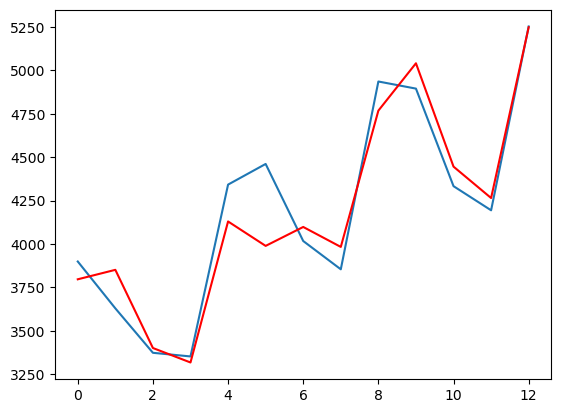

In [209]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

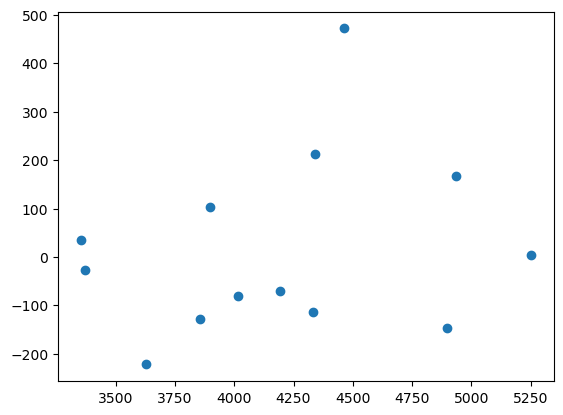

In [210]:
residuals = pd.DataFrame(test-predictions)
plt.scatter(x= test, y=residuals)
plt.show()

In [211]:
final_result = pd.concat([table_rmse1,table_rmse2], axis = 0, ignore_index=True)
final_result.loc[len(final_result.index)] = ['ARIMA',rmse_arima ] 
final_result

,MODEL,RMSE_Values
0,rmse_linear,1133.310783
1,rmse_Exp,953.725431
2,rmse_Quad,734.829776
3,rmse_add_sea,2091.074048
4,rmse_add_sea_quad,1027.071615
5,rmse_Mult_sea,2117.618988
6,rmse_Mult_add_sea,804.179072
7,simple_exp,1641.680690
8,holt,1262.654646
9,hwe_add_add,718.350803


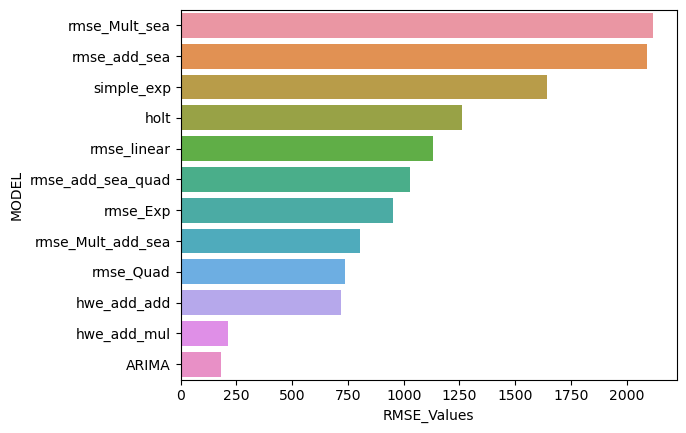

In [212]:
sns.barplot(data=final_result.sort_values(['RMSE_Values'],ascending=False), x="RMSE_Values", y="MODEL")
plt.show()

# Conclusion:
**The best model for forcasting is found to be rolling ARIMA with order = (4,2,1), and second best is Holts winter exponential smoothing with multiplicative seasonality and additive trend with RMSE values 179 and 213 respectively**

# Combine train and test data and build final model

In [223]:
X.shape

(42,)

In [267]:
model_final = ARIMA(X, order=(4,2,1))
model_results = model.fit()
output = model_fit.forecast(24)
forecasted = pd.DataFrame(output)
forecasted.columns = ["forecast"]

In [268]:
data_forecast = pd.concat([Data[["sales"]],forecasted], axis = 0).reset_index(drop=True)

<AxesSubplot:>

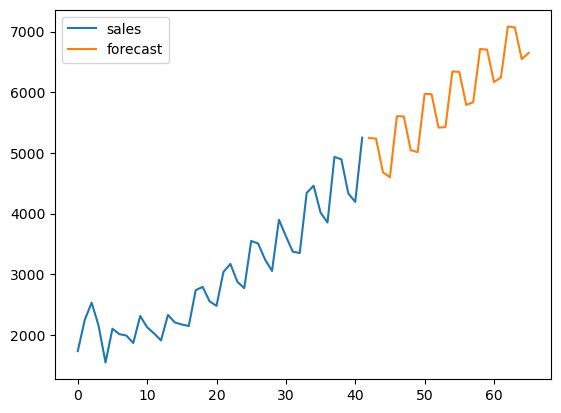

In [269]:
data_forecast.plot()